# Neural Machine Translation for (EN - NP)
This work involves fine-tuning  'google/t5-small' for translation task on 'EN-NP', using Hugging Face models and trainers.

## Environment Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q datasets sacrebleu torch transformers sentencepiece transformers[sentencepiece]
!pip install -q accelerate -U
!pip install -q wandb
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.5.0 which 

In [3]:
import torch
import pandas as pd
import os
import numpy as np
import sacrebleu
import datasets
import warnings
import sentencepiece as spm
import random
import re
import matplotlib.pyplot as plt
import evaluate
import wandb

from tqdm import tqdm
from sklearn.model_selection import train_test_split

from collections import Counter
from datasets import Dataset, load_metric
from transformers import pipeline, AutoTokenizer, T5Tokenizer, T5ForConditionalGeneration
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

warnings.filterwarnings("ignore")

In [4]:
config = {
    'EPOCHS': 10,
    'BLEU': 'bleu',
    'SRC_LANG_CODE': 'en',
    'TGT_LANG_CODE': 'np',
    'SRC_LANGUAGE': 'English',
    'TGT_LANGUAGE': 'Nepali',
    'SRC_TRAIN_RAW_PATH': '/content/drive/MyDrive/Colab Code/consolidated/train.en',
    'TGT_TRAIN_RAW_PATH': '/content/drive/MyDrive/Colab Code/consolidated/train.ne',
    'MAX_SEQ_LEN': 32,
    'BATCH_SIZE': 32,
    'DEVICE': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'MODEL_ID': 'google-t5/t5-small',
    'ENC_TYPE': 'utf-8',
    'VOCAB_SIZE': 32000,
    'MAX_SOURCE_LENGTH': 96,
    'MAX_TARGET_LENGTH': 96,
    'MAX_GEN_LENGTH': 128,
    'WEIGHT_DECAY': 0.01,
    'LR': 5e-5
}

## Model Ready Dataset Preparation

In [5]:
with open(config['SRC_TRAIN_RAW_PATH'], 'r', encoding = config['ENC_TYPE']) as f:
    en_lines = f.readlines()

with open(config['TGT_TRAIN_RAW_PATH'], 'r', encoding = config['ENC_TYPE']) as f:
    ne_lines = f.readlines()

data_df = pd.DataFrame(list(zip(en_lines, ne_lines)), columns = [config['SRC_LANG_CODE'], config['TGT_LANG_CODE']])
data_df[config['SRC_LANG_CODE']] = data_df[config['SRC_LANG_CODE']].str.replace('\n', '', regex = False)
data_df[config['TGT_LANG_CODE']] = data_df[config['TGT_LANG_CODE']].str.replace('\n', '', regex = False)

del en_lines
del ne_lines

data_df.shape, data_df.head(5)

((151937, 2),
                                                   en  \
 0  It happened after the death of Saul, when Davi...   
 1  it happened on the third day, that behold, a m...   
 2  David said to him, "Where do you come from?" H...   
 3  David said to him, "How did it go? Please tell...   
 4  David said to the young man who told him, "How...   
 
                                                   np  
 0  दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...  
 1  तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...  
 2  दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ...  
 3  दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “...  
 4  दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ...  )

In [6]:
# instruction fine-tuning
def generate_translate_prompt(row):
    src_text = row[config['SRC_LANG_CODE']]
    translate_prompt = f"Translate the given sentence from {config['SRC_LANGUAGE']} to {config['TGT_LANGUAGE']}: \"{src_text}\""
    return translate_prompt

In [7]:
data_df['input_prompt'] = data_df.apply(generate_translate_prompt, axis = 1)
data_df.head(5)

,en,np,input_prompt
0,"It happened after the death of Saul, when Davi...",दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शा...,Translate the given sentence from English to N...
1,"it happened on the third day, that behold, a m...",तब तेस्रो दिनमा एउटा जवान सैनिक सिकलगमा आयो। त...,Translate the given sentence from English to N...
2,"David said to him, ""Where do you come from?"" H...","दाऊदले त्यसलाई सोधे, “तिमी कहाँबाट आयौ?” त्यस ...",Translate the given sentence from English to N...
3,"David said to him, ""How did it go? Please tell...","दाऊदले भने, “मलाई भन, के भयो?” त्यसले भन्यो, “...",Translate the given sentence from English to N...
4,"David said to the young man who told him, ""How...","दाऊदले त्यस सैनिकलाई भने, “तिमीले कसरी जान्यौ ...",Translate the given sentence from English to N...


In [8]:
data_df.iloc[0]['en'], data_df.iloc[0]['np'], data_df.iloc[0]['input_prompt']

('It happened after the death of Saul, when David was returned from the slaughter of the Amalekites, and David had stayed two days in Ziklag;',
 'दाऊदले अमालेकीहरूलाई हराएर पछि सिकलग गए। यो शाऊलको मृत्यु भएको केही दिन पछिको कुरा हो। दाऊद त्यहाँ दुइ दिन बसे।',
 'Translate the given sentence from English to Nepali: "It happened after the death of Saul, when David was returned from the slaughter of the Amalekites, and David had stayed two days in Ziklag;"')

In [9]:
train_val_df, test_df = train_test_split(data_df, test_size = 0.05, random_state = 69)
train_df, val_df = train_test_split(train_val_df, test_size = 0.15, random_state = 69)

# huggingface dataset object
train_ds_raw = Dataset.from_pandas(train_df, split = 'train')
validation_ds_raw = Dataset.from_pandas(val_df, split = 'validation')
test_ds_raw = Dataset.from_pandas(test_df, split = 'test')

train_ds_raw

Dataset({
    features: ['en', 'np', 'input_prompt', '__index_level_0__'],
    num_rows: 122689
})

## Load Model and Tokenizer from HuggingFace

In [10]:
tokenizer = T5Tokenizer.from_pretrained(config['MODEL_ID'])
model = T5ForConditionalGeneration.from_pretrained(config['MODEL_ID'])
model.to(config['DEVICE'])

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

## Training a combined single tokenizer on EN-NP Corpus

In [11]:
def clean_text(text):
    cleaned_text = re.sub(r'\\t|\t|\n', ' ', text)

    # remove any extra space
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()

    return cleaned_text

# lets train single tokenizer on the combined corpus
with open(config['SRC_TRAIN_RAW_PATH'], 'r', encoding = config['ENC_TYPE']) as f:
    en_lines = f.readlines()

with open(config['TGT_TRAIN_RAW_PATH'], 'r', encoding = config['ENC_TYPE']) as f:
    np_lines = f.readlines()

combined_corpus = en_lines + np_lines
random.shuffle(combined_corpus)

combined_corpus = list(map(clean_text, combined_corpus))

del en_lines
del np_lines

combined_corpus[:3]

['जहिल्यै पनि प्रयोग गरिने पाठका टुक्राहरू छिटो तरिकाले घुसाउनुहोस्',
 'The committee also decided to stay a party leader and a close associate of the open party in the district.',
 'यसकोअतिरिक्त भर्खर उम्रेको बेर्नामा आक्रमण भएमा पुरै बेर्ना मर्न सक्दछ जसको फलस्वरूप रोप्ने बेलामा बेर्नाको कमी हुन जान्छ ।']

In [12]:
tokenizer = AutoTokenizer.from_pretrained(config['MODEL_ID'])
# train_tokenizer on combined corpus
new_tokenizer = tokenizer.train_new_from_iterator(combined_corpus, vocab_size = config['VOCAB_SIZE'])
new_tokenizer.save_pretrained('/content/combined-en-np-tokenizer-google-t5-small')

('/content/combined-en-np-tokenizer-google-t5-small/tokenizer_config.json',
 '/content/combined-en-np-tokenizer-google-t5-small/special_tokens_map.json',
 '/content/combined-en-np-tokenizer-google-t5-small/tokenizer.json')

In [13]:
tokenizer = AutoTokenizer.from_pretrained('/content/combined-en-np-tokenizer-google-t5-small')

In [14]:
# testing to see the working of newly trained tokenizer
rand_idx = random.randint(0, len(data_df))
nepali_eg = data_df.iloc[rand_idx]['np']
print(nepali_eg)
print(tokenizer.tokenize(nepali_eg))
print(tokenizer(nepali_eg)['input_ids'])

कार्यान्वयन पछि प्रकृयाका लागि सञ्झ्याल राख्नुहोस्
['▁कार्यान्वयन', '▁पछि', '▁प्रकृया', 'का', '▁लागि', '▁सञ्झ्याल', '▁राख्नुहोस्']
[854, 495, 6881, 118, 140, 551, 3065, 1]


In [15]:
# find the maximum lengths of source and target translations
max_src_length = 0
max_tgt_length = 0
src_token_lengths = []
tgt_token_lengths = []
for row in tqdm(data_df.iterrows(), ncols = 80):
    row_data = row[1]
    src_raw_text = row_data['en']
    tgt_raw_text = row_data['np'] # labels
    prompt_raw_text = row_data['input_prompt'] # input feature

    input_token_length = len(tokenizer(prompt_raw_text)['input_ids'])
    label_token_length = len(tokenizer(tgt_raw_text)['input_ids'])

    src_token_lengths.append(input_token_length)
    tgt_token_lengths.append(label_token_length)

    max_src_length = max(max_src_length, input_token_length)
    max_tgt_length = max(max_tgt_length, label_token_length)

print("Maximum Source Length (tokenized): ", max_src_length)
print("Maximum Target Length (tokenized): ", max_tgt_length)

63652it [00:34, 2411.04it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors
151937it [01:25, 1781.90it/s]

Maximum Source Length (tokenized):  590
Maximum Target Length (tokenized):  558


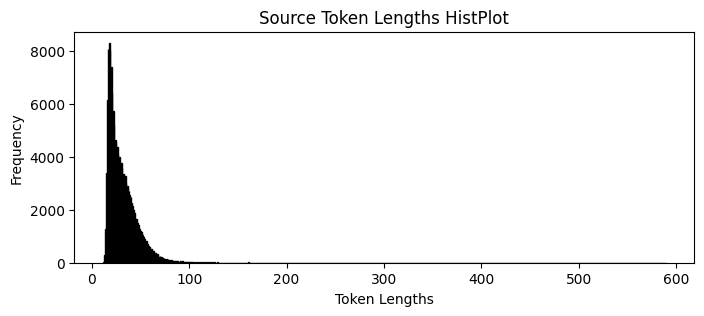

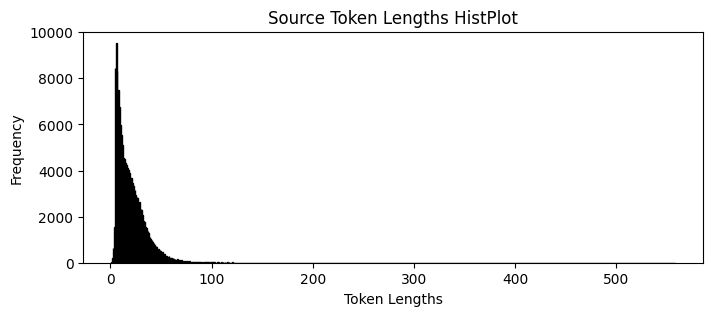

In [16]:
plt.figure(figsize = (8, 3))
plt.hist(src_token_lengths, bins = 'auto', edgecolor = 'black')

plt.xlabel('Token Lengths')
plt.ylabel('Frequency')
plt.title('Source Token Lengths HistPlot')

plt.show()
plt.figure(figsize = (8, 3))
plt.hist(tgt_token_lengths, bins = 'auto', edgecolor = 'black')

plt.xlabel('Token Lengths')
plt.ylabel('Frequency')
plt.title('Source Token Lengths HistPlot')

plt.show()

Lets set the maximum_sequence_length and maximum_target_length to 96.

In [17]:
validation_ds_raw

Dataset({
    features: ['en', 'np', 'input_prompt', '__index_level_0__'],
    num_rows: 21651
})

In [18]:
def preprocess_function(sample, padding = 'max_length'):
    model_inputs = tokenizer(sample['input_prompt'], max_length = config['MAX_SOURCE_LENGTH'], padding = padding, truncation = True)
    labels = tokenizer(text_target = sample['np'], max_length = config['MAX_TARGET_LENGTH'], padding = padding, truncation = True)


    # replacing pad_token with -100 for ignoring pad_ids while calculating loss
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train_ds = train_ds_raw.map(
    preprocess_function, batched = True,
    remove_columns = ['en', 'np', 'input_prompt', '__index_level_0__'])

tokenized_validation_ds = validation_ds_raw.map(
    preprocess_function, batched = True,
    remove_columns = ['en', 'np', 'input_prompt', '__index_level_0__'])

tokenized_test_ds = test_ds_raw.map(
    preprocess_function, batched = True,
    remove_columns = ['en', 'np', 'input_prompt', '__index_level_0__'])

Map:   0%|          | 0/122689 [00:00<?, ? examples/s]

Map:   0%|          | 0/21651 [00:00<?, ? examples/s]

Map:   0%|          | 0/7597 [00:00<?, ? examples/s]

In [19]:
metric = evaluate.load('sacrebleu')

# helper function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # Replace -100 in the labels as we can't decode them.
    # for some reason, also get a lot of -100 in preds
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [20]:
wandb.init(project = "translation-en-np", name = "t5-finetuning-en-to-np")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [21]:
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100

# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model = model,
    label_pad_token_id = label_pad_token_id,
    pad_to_multiple_of = 8
)

In [22]:
out_dir = f"{config['MODEL_ID'].split('/')[1]}-finetuned-translation-EN-NP"

training_args = Seq2SeqTrainingArguments(
    output_dir = out_dir,
    learning_rate = config['LR'],
    per_device_train_batch_size = config['BATCH_SIZE'],
    per_device_eval_batch_size = config['BATCH_SIZE'],
    generation_max_length = config['MAX_GEN_LENGTH'],
    weight_decay = config['WEIGHT_DECAY'],
    num_train_epochs = config['EPOCHS'],
    predict_with_generate = True,
    fp16 = False,
    bf16 = True,

    # logging & evaluation strategies,
    report_to = ["wandb"],
    logging_dir=f"./logs",
    logging_strategy = "steps",
    logging_steps = 50,
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
)

In [23]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset = tokenized_train_ds,
    eval_dataset = tokenized_validation_ds,
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss
